# Basic characterizations of UA Q1
### using Experiment and Analysis classes

In [1]:
from qm.qua import *
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm import SimulationConfig, LoopbackInterface
from qm.octave import *
from qm.octave.octave_manager import ClockMode
from configuration import *
from scipy import signal
from qm import SimulationConfig
from qualang_tools.bakery import baking
from qualang_tools.units import unit
from qm import generate_qua_script
from qm.octave import QmOctaveConfig
from set_octave import ElementsSettings, octave_settings
from quam import QuAM
from scipy.io import savemat
from scipy.io import loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 0 # for UA Q1
res_index = 0 # for UA Q1
flux_index = 0 # for UA Q1
TLS_index = 0 # for TLS of interest

2023-11-01 15:06:06,671 - qm - INFO     - Starting session: 25fd02dd-a91b-4fbd-ac24-dfcd0e03fbdb


In [2]:
Experiment = ExperimentHandle()
Analysis = AnalysisHandle()
machine = Analysis.get_machine()

In [6]:
# initialize Labber-controlled hardware
Experiment.set_Labber(Analysis.get_machine(), qubit_index, res_index, flux_index)
# set octave to external clock
#Experiment.set_external_clock()

In [7]:
# this updates the octave settings, including rf_gain and rf_output_mode
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = False)

2023-11-01 14:59:16,521 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-11-01 14:59:16,531 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


In [8]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)

2023-11-01 14:59:22,474 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-11-01 14:59:22,484 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r0 for (LO, IF) = (7.313 GHz, -50.000 MHz)
2023-11-01 14:59:28,556 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q0 for (LO, IF) = (6.224 GHz, 200.000 MHz)
2023-11-01 14:59:40,933 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## resonator switch calibration

### switch delay

In [ ]:
# reduce the resonator freq, so sig is stronger
machine.resonators[res_index].f_readout -= 2E6
machine._save("quam_state.json")

In [ ]:
%matplotlib inline
rr_switch_delay_sweep = np.arange(70,110,1)
machine, rr_switch_delay_sweep, sig_amp = Experiment.exp1D.RR.rr_switch_delay(rr_switch_delay_sweep, qubit_index, res_index, flux_index, 
                          n_avg = 160E3, cd_time = 20E3, simulate_flag = False, simulation_len = 500, plot_flag = True)

### switch buffer

In [ ]:
%matplotlib inline
rr_switch_buffer_sweep = np.arange(0,25 + 1,1)
machine, rr_switch_delay_sweep, sig_amp = Experiment.exp1D.RR.rr_switch_buffer(rr_switch_buffer_sweep, qubit_index, res_index, flux_index, 
                          n_avg = 20E3, cd_time = 20E3, simulate_flag = False, simulation_len = 500, plot_flag = True)

## Time of flight

In [ ]:
# time_of_flight
# experiment
machine, adc1, adc2, adc1_single, adc2_single = Experiment.exp1D.RR.time_of_flight(qubit_index,res_index,flux_index, n_avg = 10E3, cd_time = 1E3, tPath = None, f_str_datetime = None, simulate_flag = False, simulation_len = 1000)
# plot
%matplotlib inline
dc_offset_i, dc_offset_q, delay = Analysis.exp1D.time_of_flight(adc1,adc2,adc1_single,adc2_single)

In [ ]:
# update the offset
machine.global_parameters.con1_downconversion_offset_I += -0.000341
machine.global_parameters.con1_downconversion_offset_Q += -0.000633
machine = Analysis.set_machine(machine)

## 1D RO resonator spectroscopy

In [18]:
%matplotlib qt
machine = Analysis.get_machine()
res_freq_sweep = machine.resonators[res_index].f_readout + np.arange(-10E6,10E6 + 1.0,0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                           n_avg = 1E3, cd_time = 5E3, simulate_flag = False, simulation_len = 1000)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 2.15s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 2.24s


resonator frequency: 7262.900 MHz
Execution stopped by user!


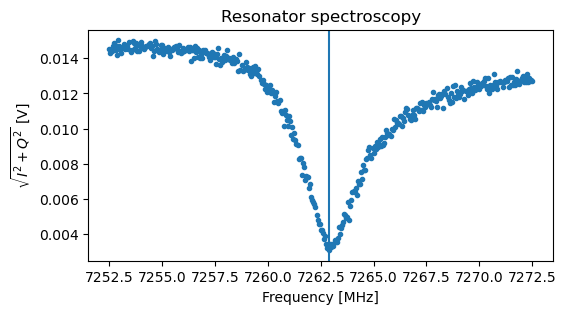

In [19]:
# find the minimal
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
machine.resonators[res_index].f_readout = res_freq.tolist() + 0E6
machine = Analysis.set_machine(machine)

## 2D RO resonator spectroscopy vs DC flux

In [ ]:
res_freq_sweep = np.arange(7.254E9,7.267E9 + 1.0,0.2E6)
dc_flux_sweep = np.arange(-9,9.001,0.5)
%matplotlib qt
machine, res_freq_sweep, dc_flux_sweep, sig_amp = Experiment.exp2D.RR.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, qubit_index, res_index, flux_index, n_avg = 1E3, cd_time = 10E3)

In [ ]:
%matplotlib inline
ham_param = Analysis.exp2D.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, sig_amp, init_guess = None)
poly_param = Analysis.exp2D.qubit_vs_dc_flux_guess(ham_param)

In [ ]:
# save the fitting parameters
machine.resonators[res_index].tuning_curve = ham_param.tolist()
machine.qubits[qubit_index].tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)

In [ ]:
# save the sweep spot flux according to fitted parameter
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(machine.qubits[qubit_index].tuning_curve)
machine = Analysis.set_machine(machine)

## 1D qubit spectroscopy @ sweep spot

In [20]:
# set to sweet spot
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 5.69s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 5.73s
resonator frequency: 7263.113 MHz


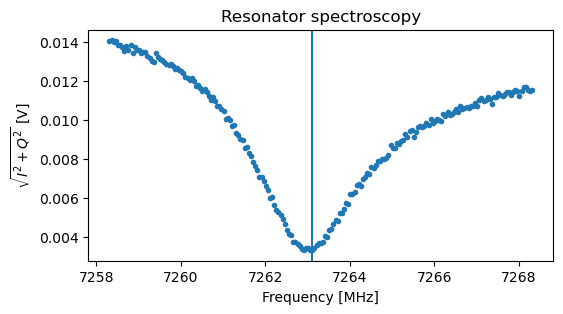

In [24]:
# calibrate RO
%matplotlib qt
#res_freq_sweep = np.arange(7.2575E9,7.2675E9 + 1.0,0.03E6)
ham_param = machine.resonators[res_index].tuning_curve
res_freq_est = Analysis.exp2D.ham([flux_index,machine.flux_lines[flux_index].max_frequency_point], ham_param[0], ham_param[1], ham_param[2], ham_param[3], ham_param[4], ham_param[5], output_flag = 1) * 1E6 # to Hz
res_freq_sweep = int(res_freq_est[0]) + np.arange(-5E6, 5E6 + 1, 0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                       n_avg = 5E3, cd_time = 5E3, plot_flag = False, simulate_flag = False, simulation_len = 1000)
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
res_freq = int(res_freq.tolist())
machine.resonators[res_index].f_readout = res_freq + 0E6
machine.resonators[res_index].lo = res_freq + 50E6
machine = Analysis.set_machine(machine)

In [ ]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index)

In [22]:
#qubit_freq_sweep = np.arange(6.30E9,6.60E9+1,1E6)
# for the DC flux
#qubit_freq_est = np.polyval(machine.qubits[qubit_index].tuning_curve,machine.flux_lines[flux_index].max_frequency_point) * 1E6 # in Hz
# for the fast flux
qubit_freq_est = np.polyval(machine.qubits[qubit_index].tuning_curve,0.0) * 1E6 # in Hz
machine.qubits[qubit_index].lo = int(qubit_freq_est.tolist()) - 200E6
qubit_freq_sweep = int(qubit_freq_est) + np.arange(-50E6, 50E6 + 1, 1E6)
    
%matplotlib qt
machine, qubit_freq_sweep, sig_amp = Experiment.exp1D.Rabi.qubit_freq(qubit_freq_sweep, qubit_index, res_index, flux_index, 
                                      pi_amp_rel = 1.0, ff_amp = 0.0, n_avg = 2E3, cd_time = 20E3, plot_flag = False, 
                                      simulate_flag = False, simulation_len = 4000)

Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 4.18s
Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 4.23s


resonant frequency: 6424.165 MHz


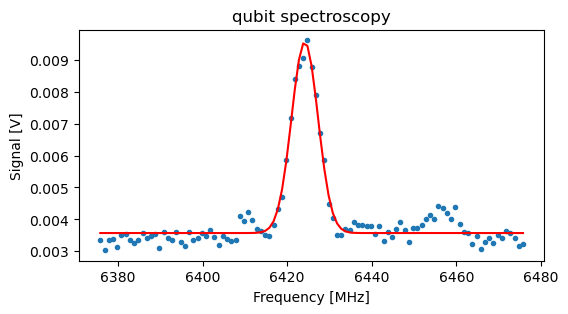

In [23]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=qubit_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq - 200E6
machine = Analysis.set_machine(machine)

In [23]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine)

2023-11-01 13:57:55,177 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-11-01 13:57:55,189 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r0 for (LO, IF) = (7.313 GHz, -50.113 MHz)
2023-11-01 13:58:02,213 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q0 for (LO, IF) = (6.216 GHz, 200.000 MHz)
2023-11-01 13:58:13,722 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## Rabi

### time rabi

In [20]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 80 + 0.1, 2)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, n_avg = 2E3, cd_time = 20E3, plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 1.62s
Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 1.66s


rabi_pi_pulse: 93.8 ns
half period: 91.06 ns


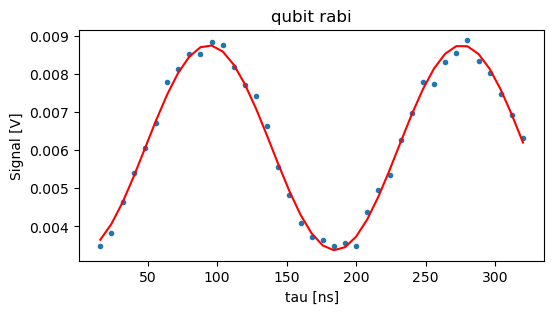

In [21]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,plot_flag = True)

In [27]:
machine.qubits[qubit_index].pi_length[0] = 100
machine = Analysis.set_machine(machine)

### power rabi

In [17]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.3, 2.0, 0.05) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, 
                                          n_avg = 4E3, cd_time = 40E3, plot_flag = False, machine = machine)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 5.48s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 5.53s


In [18]:
%matplotlib qt
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

rabi_pi_pulse_amp: 0.02356 V
half period: 0.02224 V


In [19]:
machine.qubits[qubit_index].pi_amp[0] = pi_pulse_amp.tolist()
machine = Analysis.set_machine(machine)

## calibrate qubit XY line switch

### switch delay

In [8]:
%matplotlib inline
qubit_switch_delay_sweep = np.arange(70,110,1)
for i in range(4):
    machine, qubit_switch_delay_sweep, sig_amp = Experiment.exp1D.Rabi.qubit_switch_delay(qubit_switch_delay_sweep, qubit_index, res_index, flux_index, 
                              n_avg = 160E3, cd_time = 20E3, simulate_flag = False, simulation_len = 500, plot_flag = False)

Progress: [##################################################] 100.0% (n=40/40) --> elapsed time: 206.91s
Progress: [##################################################] 100.0% (n=40/40) --> elapsed time: 206.26s
Progress: [##################################################] 100.0% (n=40/40) --> elapsed time: 206.20s
Progress: [##################################################] 100.0% (n=40/40) --> elapsed time: 206.12s


### switch buffer

Progress: [##################################################] 100.0% (n=36/36) --> elapsed time: 73.07s
Progress: [##################################################] 100.0% (n=36/36) --> elapsed time: 73.37s
Progress: [##################################################] 100.0% (n=36/36) --> elapsed time: 73.42s
Progress: [##################################################] 100.0% (n=36/36) --> elapsed time: 76.03s
Progress: [##################################################] 100.0% (n=36/36) --> elapsed time: 75.50s


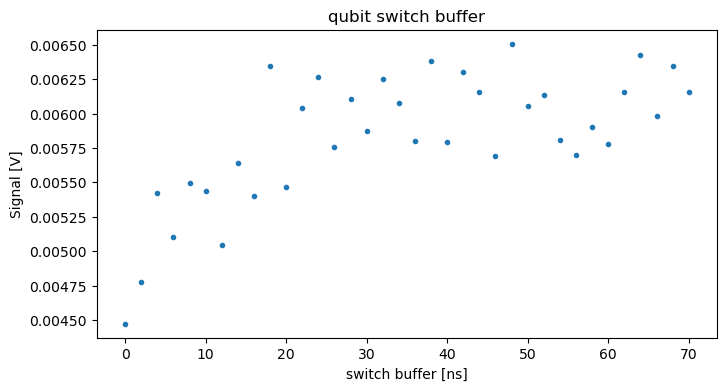

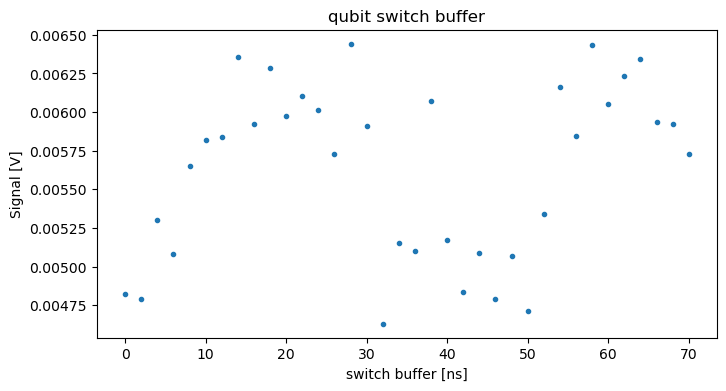

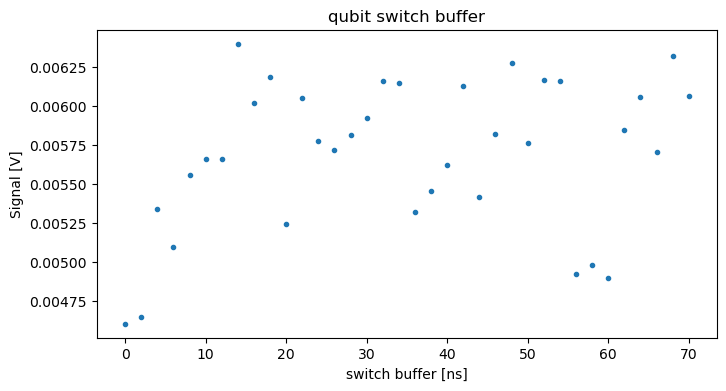

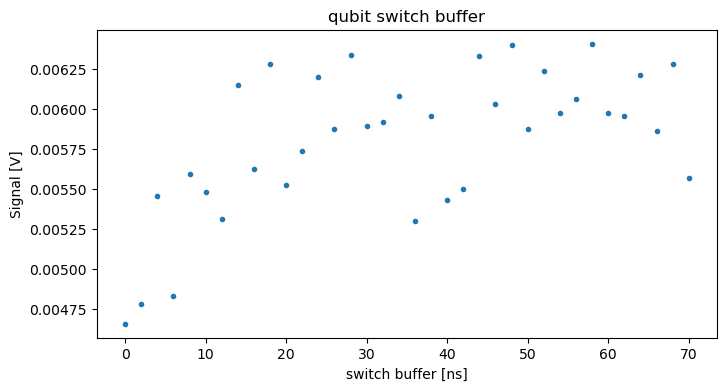

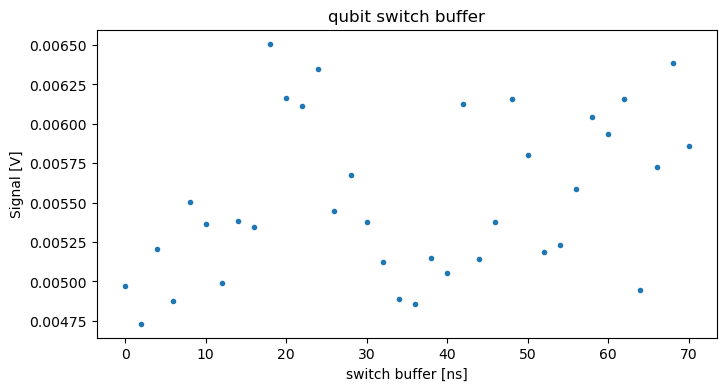

In [7]:
%matplotlib inline
qubit_switch_buffer_sweep = np.arange(0,70 + 1,2)
for k in range(5):
    machine, qubit_switch_buffer_sweep, sig_amp = Experiment.exp1D.Rabi.qubit_switch_buffer(qubit_switch_buffer_sweep, qubit_index, res_index, flux_index, 
                              n_avg = 20E3, cd_time = 20E3, simulate_flag = False, simulation_len = 500, plot_flag = True)

## T1

In [ ]:
%matplotlib qt
tau_sweep_abs = np.arange(100,30E3+1,400)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.qubit_T1(tau_sweep_abs, qubit_index, res_index, flux_index, 
                   n_avg = 5E3, cd_time = 80E3, simulate_flag = False, simulation_len = 15_000, plot_flag = False)

In [ ]:
%matplotlib inline
q1_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")
machine.qubits[qubit_index].T1 = int(q1_T1.tolist())
machine = Analysis.set_machine(machine)

## Ramsey

## ef transition

## 2D qubit spectroscopy vs dc flux

In [ ]:
# try the experiment
%matplotlib qt
dc_flux_sweep = machine.flux_lines[flux_index].max_frequency_point + np.arange(-0.6,0.6+1E-4,0.05)
_,qubit_freq_sweep,dc_flux_sweep,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_dc_flux(dc_flux_sweep,qubit_index,res_index,flux_index,
                                 n_avg = 2E3, cd_time = 10E3, pi_amp_rel = 1.0, plot_flag = True)

In [ ]:
# udpate the sweet spot
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 2, plot_flag = False)
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(poly_param).tolist() + 0E1
print(f"sweet spot flux: {machine.flux_lines[flux_index].max_frequency_point:.5f} V")

In [ ]:
# save the sweep spot flux according to fitted parameter
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

## 2D qubit spectroscopy vs fast flux

In [ ]:
# set DC voltage to sweet spot, after possible dc flux sweep
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)
machine = Analysis.set_machine(machine)

### slow version, compiling 1D scans

In [ ]:
# try the experiment
%matplotlib qt
ff_sweep = np.arange(0.0,0.3+1E-4,0.05)
qubit_if_sweep = np.arange(-100E6, 100E6 + 1, 2E6)
machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(ff_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index,ff_to_dc_ratio = None, n_avg = 1E3, cd_time = 10E3, pi_amp_rel = 1.0, plot_flag = True)

In [ ]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

### fast version, runs blockwise 2D sweeps

In [24]:
# try the experiment
%matplotlib qt
q_freq_max = np.floor(np.polyval(machine.qubits[qubit_index].tuning_curve, 0.0) * 1E6)
#ff_sweep_abs = np.arange(0.0,0.3+1E-4,0.05)
#qubit_freq_sweep = np.arange(q_freq_max, 6.2E9, -4E6)
qubit_freq_sweep = np.arange(4.8E9,4.5E9,-4E6)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 0.5E6)
machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux(qubit_freq_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index, n_avg = 1E3, cd_time = 20E3, pi_amp_rel = 1.0, plot_flag = True)

-------------------------------------some fast flux > 0.5V, removed from experiment run
2023-11-01 14:14:15,476 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-11-01 14:14:15,486 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r0 for (LO, IF) = (7.313 GHz, -50.000 MHz)
2023-11-01 14:14:22,503 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q0 for (LO, IF) = (4.500 GHz, 200.000 MHz)
2023-11-01 14:14:35,272 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 253.92s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 254.07s
2023-11-01 14:19:04,697 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-11-01 14:19:04,711 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r0 for (LO, IF) = (7.313 GHz, -50.000 MHz)
2023-11-01 14:19:11,884 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q0 for (LO, IF) = (4.300 GHz, 200.000 MHz)
2023-11-01 14:19:23,295 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 75.96s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 76.13s
Execution stopped by user!
Execution stopped by user!


In [ ]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

# TLS experiments

## TLS SWAP spectroscopy

### coarse, no baking

In [ ]:
%matplotlib qt
tau_sweep_abs = np.arange(16,200,4)
ff_sweep_abs = np.arange(0.4,0.5,0.001)
machine, ff_sweep_abs, tau_sweep_abs, sig_amp = Experiment.exp2D.SWAP.swap_coarse(tau_sweep_abs, ff_sweep_abs, qubit_index, res_index, flux_index, 
                      n_avg = 1E3, cd_time = 20E3, simulate_flag=False, simulation_len=10_000, plot_flag=True, machine = machine)

### fine, with baking

In [3]:
%matplotlib qt
tau_sweep_abs = np.arange(4,120,2)
ff_sweep_abs = np.arange(0.3,0.33,0.001)
machine, ff_sweep_abs, tau_sweep_abs, sig_amp = Experiment.exp2D.SWAP.swap_fine(tau_sweep_abs, ff_sweep_abs, qubit_index, res_index, flux_index, 
                      n_avg = 1E3, cd_time = 40E3, simulate_flag=False, simulation_len=10_000, plot_flag=True, machine = machine)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 74.45s
Execution stopped by user!


In [ ]:
machine.flux_lines[flux_index].iswap.length.append(30)
machine.flux_lines[flux_index].iswap.level.append(0.314)
machine = Analysis.set_machine(machine)

## TLS T1

In [9]:
%matplotlib qt
tau_sweep_abs = np.arange(100,20E3+1,200)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.TLS_T1(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index,
                   n_avg = 5E3, cd_time = 60E3, simulate_flag = False, simulation_len = 15_000, plot_flag = True)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 35.50s
Execution stopped by user!
Execution stopped by user!


Qubit T1 [us]: 6.69212336635424


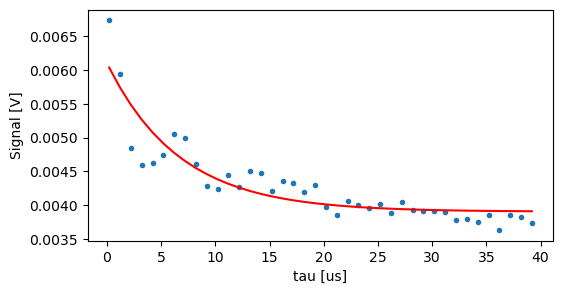

In [7]:
%matplotlib inline
q1_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")

## TLS drive

In [12]:
%matplotlib qt
TLS_freq_sweep = np.arange(5.6E9,5.8E9+1,0.5E6)
machine, TLS_freq_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_freq(TLS_freq_sweep, qubit_index, res_index, flux_index, TLS_index,
                  pi_amp_rel = 1.0, n_avg = 2E3, cd_time_qubit = 5E3, cd_time_TLS = 50E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = None)

TLS if range > 350MHz, changing LO...


TypeError: cannot unpack non-iterable NoneType object

### test